In [1]:
import tensorflow as tf
import sklearn as sk
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tqdm
from sklearn.preprocessing import OneHotEncoder

IMAGE_SIZE = 64
DATA_PATH = "./asl/asl_alphabet_train/asl_alphabet_train"
RANDOM_STATE = 0
MAX_IMAGES_PER_CLASS = 1200

In [2]:
def preprocess_data(filepath: str):
    
    # Init output data
    x_data = []
    y_data = []
    
    # For each class folder
    for label in os.listdir(filepath):

        # Initialize variables to retrieve and store images
        curr_path = filepath + "/" + label

        # For each image
        for filename in tqdm.tqdm(os.listdir(curr_path)[:MAX_IMAGES_PER_CLASS]):

            # Store image in tensor representation
            image_path = curr_path + "/" + filename
            image_file = cv2.imread(image_path)
            image_tensor = cv2.resize(image_file, (IMAGE_SIZE, IMAGE_SIZE))
            assert(image_tensor.shape == (IMAGE_SIZE, IMAGE_SIZE, 3))

            # Add tensor to data dictionary
            x_data.append(image_tensor.astype('float32') / 255.0)
            y_data.append(label)

            # debugging
            # plt.imshow(image_tensor / 255.0)
            # plt.show()
            
    
    encoder = OneHotEncoder()
    y_data_enc = encoder.fit_transform(np.array(y_data).reshape(-1, 1)).toarray()
    return np.array(x_data), y_data_enc, encoder

In [4]:
x, y, encoder = preprocess_data(DATA_PATH)

100%|█████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:04<00:00, 245.04it/s]


(array([1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1200., 1200.]),
 array([ 0.        ,  0.96551724,  1.93103448,  2.89655172,  3.86206897,
         4.82758621,  5.79310345,  6.75862069,  7.72413793,  8.68965517,
         9.65517241, 10.62068966, 11.5862069 , 12.55172414, 13.51724138,
        14.48275862, 15.44827586, 16.4137931 , 17.37931034, 18.34482759,
        19.31034483, 20.27586207, 21.24137931, 22.20689655, 23.17241379,
        24.13793103, 25.10344828, 26.06896552, 27.03448276, 28.        ]),
 <a list of 29 Patch objects>)

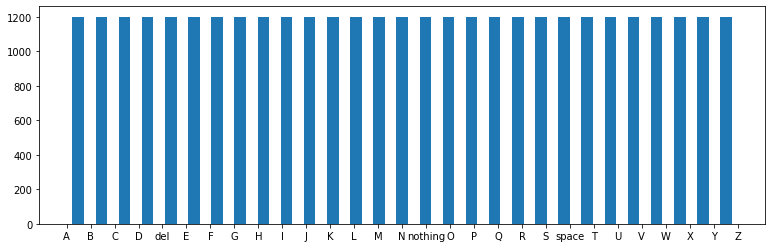

In [5]:
plt.figure(figsize=(13, 4))
plt.hist(encoder.inverse_transform(y), bins=29, rwidth=0.5)

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into testing and training inputs and labels
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, 
                                                    random_state=RANDOM_STATE)

# Print shapes of datasets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26100, 64, 64, 3) (8700, 64, 64, 3) (26100, 29) (8700, 29)


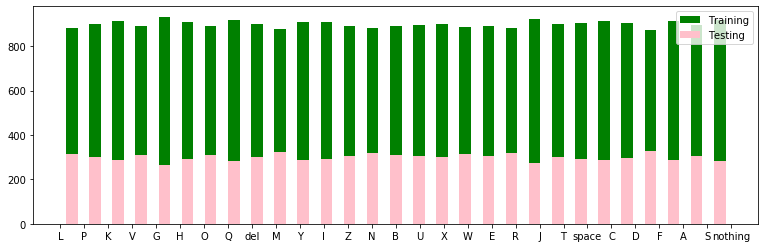

In [7]:
# Display histogram of labels for training and testing
plt.figure(figsize=(13, 4))
plt.hist(encoder.inverse_transform(y_train), bins=29, color="green", rwidth=0.5)
plt.hist(encoder.inverse_transform(y_test), bins=29, color="pink", rwidth=0.5)
plt.legend(["Training", "Testing"])

In [8]:
from sklearn.linear_model import LogisticRegression

log_reg_y_train = encoder.inverse_transform(y_train)
log_reg_y_test = encoder.inverse_transform(y_test)
log_reg_x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)
log_reg_x_test = x_test.reshape(x_test.shape[0], IMAGE_SIZE * IMAGE_SIZE * 3)
print(log_reg_y_train.shape, log_reg_x_train.shape)

log_reg_model = LogisticRegression(multi_class='multinomial', max_iter=20, solver="saga")

(26100, 1) (26100, 12288)


In [9]:
log_reg_model.fit(log_reg_x_train, log_reg_y_train.reshape(log_reg_y_train.shape[0]))

C:\Users\12039\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=20, multi_class='multinomial', solver='saga')

0.8162005671953905
0.8330268199233717
0.834959000019423
0.8330268199233717


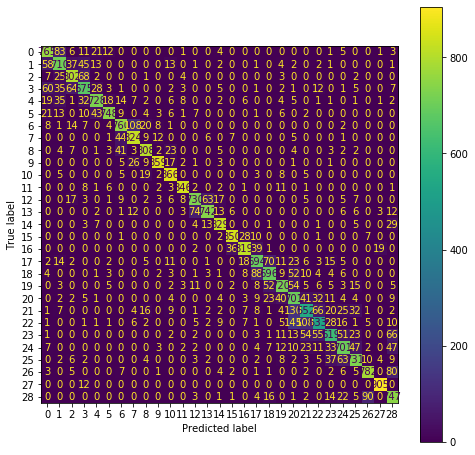

In [115]:
from sklearn.metrics import accuracy_score, precision_score, log_loss, recall_score, ConfusionMatrixDisplay, confusion_matrix, auc
log_reg_y_pred = log_reg_model.predict(log_reg_x_train)
log_reg_y_pred_probs = log_reg_model.predict_proba(log_reg_x_train)

print(log_loss(log_reg_y_train, log_reg_y_pred_probs))
print(accuracy_score(log_reg_y_train, log_reg_y_pred))
print(precision_score(log_reg_y_train, log_reg_y_pred, average='weighted'))
print(recall_score(log_reg_y_train, log_reg_y_pred, average='weighted'))

fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(log_reg_y_train, log_reg_y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.show()

0.8939333497500047
0.8044827586206896
0.8063782673940243
0.8044827586206896
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'nothing' 'space']


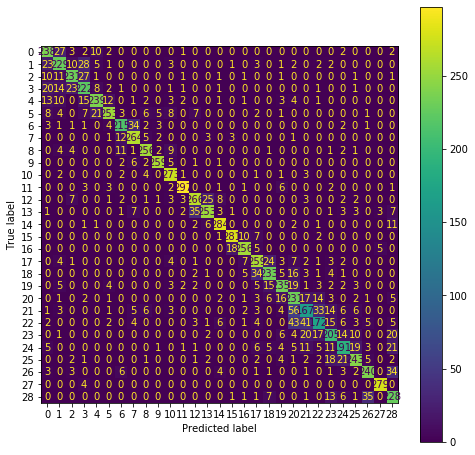

In [116]:
log_reg_y_pred = log_reg_model.predict(log_reg_x_test)
log_reg_y_pred_probs = log_reg_model.predict_proba(log_reg_x_test)

print(log_loss(log_reg_y_test, log_reg_y_pred_probs))
print(accuracy_score(log_reg_y_test, log_reg_y_pred))
print(precision_score(log_reg_y_test, log_reg_y_pred, average='weighted'))
print(recall_score(log_reg_y_test, log_reg_y_pred, average='weighted'))

print(log_reg_model.classes_)
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(log_reg_y_test, log_reg_y_pred)
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.show()

['S' 'F' 'H' 'G' 'Q' 'X' 'space' 'D' 'C' 'J' 'J' 'S' 'C' 'Z' 'U' 'nothing'
 'A' 'Q' 'K' 'U' 'A' 'del' 'B' 'C' 'N']


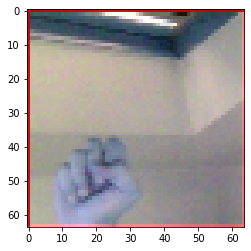

['S']
S


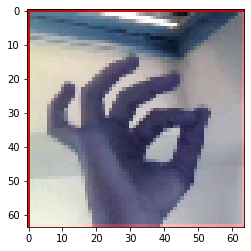

['F']
F


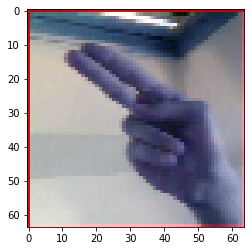

['H']
H


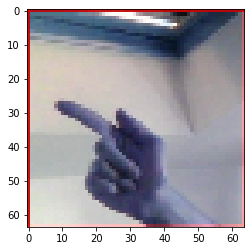

['G']
G


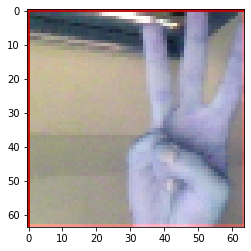

['W']
Q


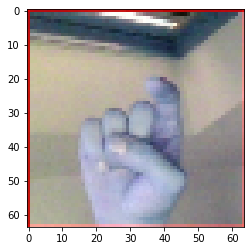

['X']
X


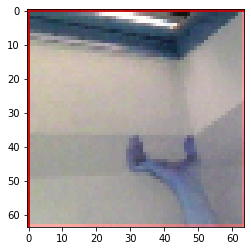

['space']
space


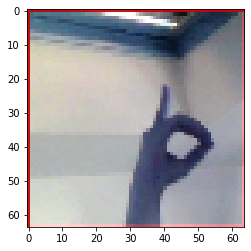

['D']
D


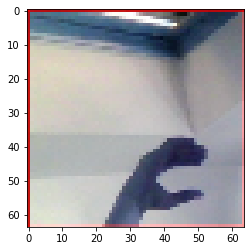

['C']
C


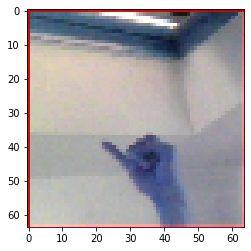

['J']
J


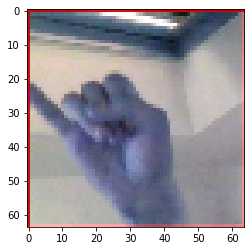

['J']
J


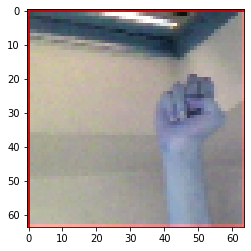

['S']
S


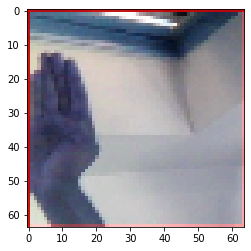

['B']
C


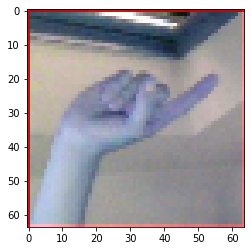

['Z']
Z


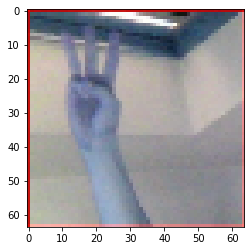

['W']
U


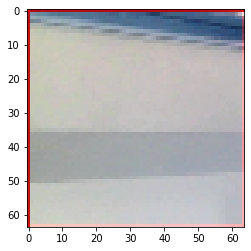

['nothing']
nothing


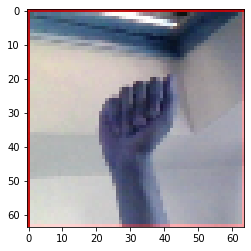

['A']
A


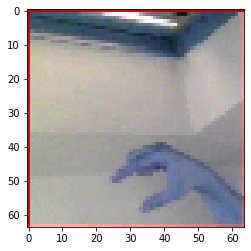

['Q']
Q


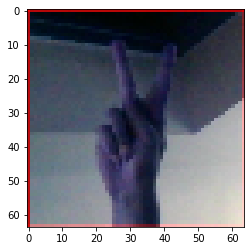

['K']
K


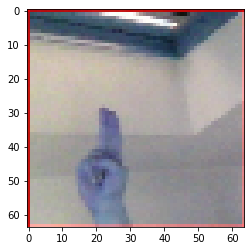

['U']
U


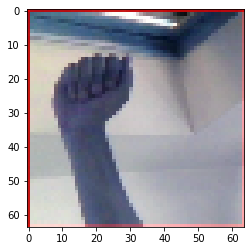

['A']
A


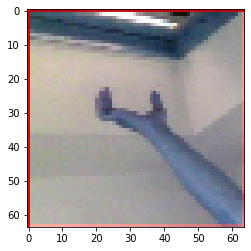

['space']
del


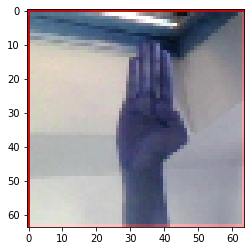

['B']
B


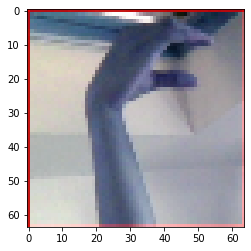

['C']
C


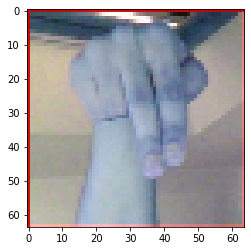

['N']
N


In [11]:
TEST = 234
TEST_1 = 25
tensors = log_reg_x_test[TEST:TEST + TEST_1]
predicts = log_reg_model.predict(tensors)
print(predicts)
for i in range(0, TEST_1):
    
    entry = i + TEST
    predict = predicts[i]
    tensor = log_reg_x_test[entry]
    plt.imshow(tensor.reshape(64, 64, 3))
    plt.show()
    print(log_reg_y_test[i + TEST])
    print(predict)


In [74]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten

model = Sequential()
model.add(Conv2D(10, (8, 8), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(MaxPooling2D((4, 4)))
model.add(Conv2D(10, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(10, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 57, 57, 10)        1930      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 12, 10)        910       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 10)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 10)          910       
_________________________________________________________________
flatten_2 (Flatten)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [75]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall, AUC

model.compile(loss="categorical_crossentropy", metrics=[CategoricalAccuracy(), Precision(), Recall(), AUC()])

In [77]:
model_history = model.fit(x=x_train, y=y_train, epochs=30, verbose=2, validation_data=(x_test, y_test), batch_size=50)

Epoch 1/30
522/522 - 26s - loss: 1.6988 - categorical_accuracy: 0.4693 - precision_4: 0.8437 - recall_4: 0.2859 - auc_2: 0.9356 - val_loss: 1.3934 - val_categorical_accuracy: 0.5793 - val_precision_4: 0.8899 - val_recall_4: 0.3641 - val_auc_2: 0.9588
Epoch 2/30
522/522 - 29s - loss: 1.2745 - categorical_accuracy: 0.5937 - precision_4: 0.8542 - recall_4: 0.4270 - auc_2: 0.9654 - val_loss: 1.2784 - val_categorical_accuracy: 0.5877 - val_precision_4: 0.8408 - val_recall_4: 0.4397 - val_auc_2: 0.9643
Epoch 3/30
522/522 - 26s - loss: 0.9940 - categorical_accuracy: 0.6808 - precision_4: 0.8596 - recall_4: 0.5460 - auc_2: 0.9787 - val_loss: 0.8349 - val_categorical_accuracy: 0.7345 - val_precision_4: 0.8816 - val_recall_4: 0.6152 - val_auc_2: 0.9850
Epoch 4/30
522/522 - 26s - loss: 0.8014 - categorical_accuracy: 0.7400 - precision_4: 0.8768 - recall_4: 0.6367 - auc_2: 0.9859 - val_loss: 0.7180 - val_categorical_accuracy: 0.7702 - val_precision_4: 0.8881 - val_recall_4: 0.6659 - val_auc_2: 0.9

In [78]:
print(model_history.history["val_categorical_accuracy"])

[0.5793103575706482, 0.587701141834259, 0.7344827651977539, 0.7702298760414124, 0.8226436972618103, 0.8250574469566345, 0.8136781454086304, 0.8208045959472656, 0.8921838998794556, 0.9177011251449585, 0.8989655375480652, 0.9309195280075073, 0.9112643599510193, 0.931034505367279, 0.9242528676986694, 0.9490804672241211, 0.9451724290847778, 0.9543678164482117, 0.9381608963012695, 0.9560919404029846, 0.9332184195518494, 0.9622988700866699, 0.9618390798568726, 0.9645977020263672, 0.9716091752052307, 0.9636781811714172, 0.953218400478363, 0.9724137783050537, 0.9791954159736633, 0.972183883190155]


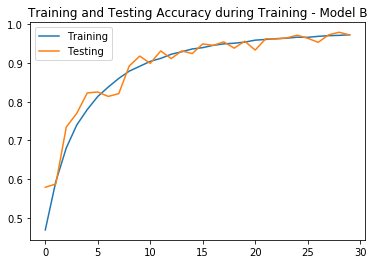

In [82]:
plt.plot(model_history.history["categorical_accuracy"])
plt.plot(model_history.history["val_categorical_accuracy"])
plt.legend(["Training", "Testing"])
plt.title("Training and Testing Accuracy during Training - Model B")
plt.show()

In [79]:
model.evaluate(x_test, y_test, verbose=1)

272/272 [==============================] - ETA: 0s - loss: 0.0051 - categorical_accuracy: 1.0000 - precision_4: 1.0000 - recall_4: 1.0000 - auc_2: 1.000 - ETA: 1s - loss: 0.1016 - categorical_accuracy: 0.9648 - precision_4: 0.9686 - recall_4: 0.9648 - auc_2: 0.997 - ETA: 1s - loss: 0.0982 - categorical_accuracy: 0.9729 - precision_4: 0.9770 - recall_4: 0.9729 - auc_2: 0.997 - ETA: 1s - loss: 0.2393 - categorical_accuracy: 0.9716 - precision_4: 0.9757 - recall_4: 0.9688 - auc_2: 0.997 - ETA: 1s - loss: 0.2036 - categorical_accuracy: 0.9677 - precision_4: 0.9739 - recall_4: 0.9655 - auc_2: 0.997 - ETA: 1s - loss: 0.1744 - categorical_accuracy: 0.9688 - precision_4: 0.9755 - recall_4: 0.9670 - auc_2: 0.998 - ETA: 1s - loss: 0.1632 - categorical_accuracy: 0.9688 - precision_4: 0.9744 - recall_4: 0.9673 - auc_2: 0.998 - ETA: 1s - loss: 0.1508 - categorical_accuracy: 0.9700 - precision_4: 0.9754 - recall_4: 0.9681 - auc_2: 0.998 - ETA: 1s - loss: 0.1637 - categorical_accuracy: 0.9688 - preci

[0.10280204564332962,
 0.972183883190155,
 0.9749220013618469,
 0.9696551561355591,
 0.9985504746437073]

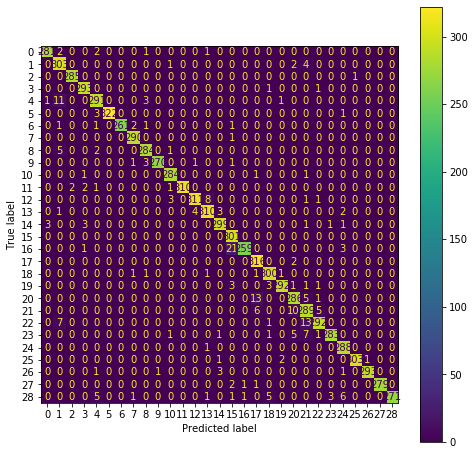

In [73]:
y_pred = [np.argmax(probs) for probs in model.predict(x_test)]
y_true_lbls = encoder.inverse_transform(y_test)
y_true_idxs = [list(encoder.categories_[0]).index(entry) for entry in y_true_lbls]
cm = confusion_matrix(y_true_idxs, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay(cm).plot(ax=ax)
plt.show()

(26100, 64, 64, 3)
[array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'del', 'nothing', 'space'], dtype='<U7')]


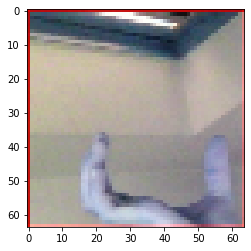

[['space']]
space


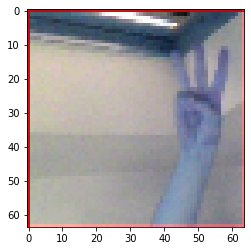

[['W']]
W


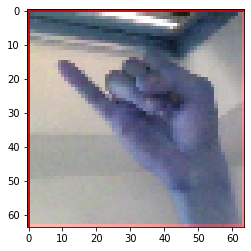

[['J']]
J


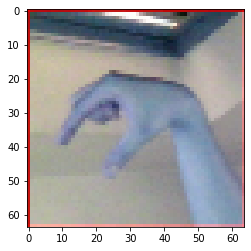

[['Q']]
Q


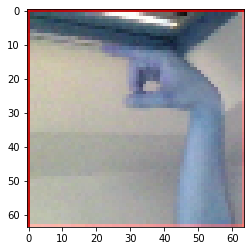

[['P']]
P


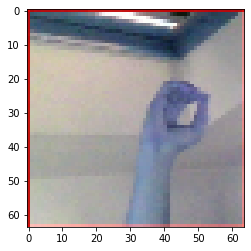

[['O']]
O


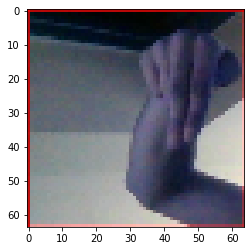

[['N']]
N


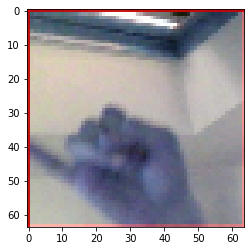

[['J']]
J


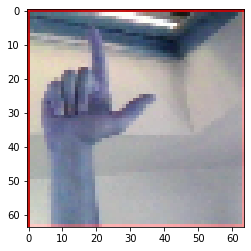

[['L']]
L


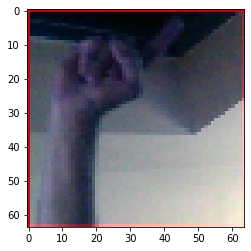

[['Z']]
Z


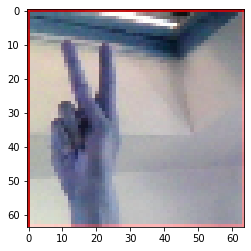

[['K']]
K


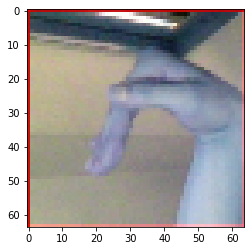

[['del']]
del


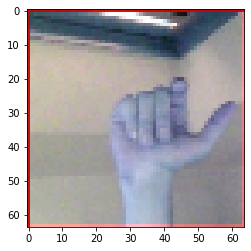

[['T']]
T


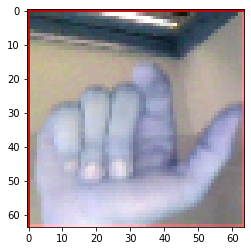

[['T']]
T


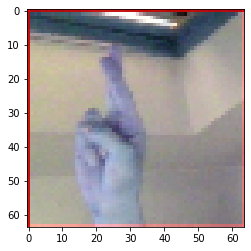

[['R']]
R


In [53]:
print(x_train.shape)
TEST = np.random.randint(0, 1000)
TEST_1 = 15
tensors = x_test[TEST:TEST + TEST_1]
predicts = model.predict(tensors)
print(encoder.categories_)
for i in range(0, TEST_1):
    
    entry = i + TEST
    predict = np.argmax(predicts[i])
    tensor = x_test[entry]
    plt.imshow(tensor)
    plt.show()
    print(encoder.inverse_transform(np.array(y_test[entry]).reshape(1, -1)))
    print(encoder.categories_[0][predict])
